In [33]:
import json
import random
import datetime
import re
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup
from wordcloud import WordCloud

In [4]:
seed = 71
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Loading Data
- Since the original data is stored in separate files by category, create and manage a list of categories.
- Due to the massive amount of data and significant discrepancies in data volume across categories, perform sampling by category and year.

In [5]:
with open('Categories.txt', 'r') as file:
    FULL_CATEGORY_LIST = file.read()
FULL_CATEGORY_LIST = FULL_CATEGORY_LIST.split('\n')
TRAIN_CATEGORIES = random.sample(FULL_CATEGORY_LIST, int(len(FULL_CATEGORY_LIST)*0.8))
TEST_CATEGORIES = list(set(FULL_CATEGORY_LIST) - set(TRAIN_CATEGORIES))
print(f"Categories for training: {str(TRAIN_CATEGORIES)}")
print(f"Categories for test: {str(TEST_CATEGORIES)}")

Categories for training: ['Electronics', 'Pet_Supplies', 'Sports_and_Outdoors', 'All_Beauty', 'CDs_and_Vinyl', 'Amazon_Fashion', 'Health_and_Personal_Care', 'Baby_Products', 'Toys_and_Games']
Categories for test: ['Unknown', 'Home_and_Kitchen', 'Books']


In [6]:
train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

def sampling_data(file_path, num_sample):
    print(f"Start {file_path}")
    sampled_data = list()
    total_counts = defaultdict(int)
    counts = defaultdict(int)
    with open(file_path, 'r') as fp:
        for line in fp:
            data = json.loads(line.strip())
            year = datetime.datetime.fromtimestamp(data['timestamp']/1000).year
            total_counts[year] += 1
            data['year'] = year
            if counts[year] < num_sample:
                sampled_data.append(data)
                counts[year] += 1
            else:
                r = random.randint(0, total_counts[year] - 1)
                if r < num_sample:
                    sampled_data[r] = data
    return sampled_data

for cat in FULL_CATEGORY_LIST:
    df_smapled = sampling_data(file_path = f"./rawdata/{cat}.jsonl", num_sample = 3000)
    df_smapled = pd.DataFrame(df_smapled)
    df_smapled['category'] = cat
    if cat in TRAIN_CATEGORIES:
        train_dataset = df_smapled if train_dataset.empty else pd.concat([train_dataset, df_smapled])
    else:
        test_dataset = df_smapled if test_dataset.empty else pd.concat([test_dataset, df_smapled])


Start ./rawdata/All_Beauty.jsonl
Start ./rawdata/Amazon_Fashion.jsonl
Start ./rawdata/Baby_Products.jsonl
Start ./rawdata/Books.jsonl
Start ./rawdata/CDs_and_Vinyl.jsonl
Start ./rawdata/Electronics.jsonl
Start ./rawdata/Health_and_Personal_Care.jsonl
Start ./rawdata/Home_and_Kitchen.jsonl
Start ./rawdata/Pet_Supplies.jsonl
Start ./rawdata/Sports_and_Outdoors.jsonl
Start ./rawdata/Toys_and_Games.jsonl
Start ./rawdata/Unknown.jsonl


# EDA
- Dataset sizes: Train dataset (517949, 12), Test dataset (226525, 12)

In [7]:
print(f"Train dataset shape: {train_dataset.shape}")
print(f"Test dataset shape: {test_dataset.shape}")

Train dataset shape: (517949, 12)
Test dataset shape: (226525, 12)


- "title": Review title, "text": Review content
- The dataset seems to contain reviews not only in English, but also in Spanish.

In [8]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517949 entries, 0 to 65367
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             517949 non-null  float64
 1   title              517949 non-null  object 
 2   text               517949 non-null  object 
 3   images             517949 non-null  object 
 4   asin               517949 non-null  object 
 5   parent_asin        517949 non-null  object 
 6   user_id            517949 non-null  object 
 7   timestamp          517949 non-null  int64  
 8   helpful_vote       517949 non-null  int64  
 9   verified_purchase  517949 non-null  bool   
 10  year               517949 non-null  int64  
 11  category           517949 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 47.9+ MB


In [9]:
train_dataset.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,year,category
0,5.0,Perfection!,I absolutely love this oil!! The smell is amaz...,[],B07KTK1CNT,B07KTK1CNT,AF2YTD25I3G7XGLSZ46RQD5RRW7Q,1678834623373,0,False,2023,All_Beauty
1,1.0,Bad product,Brush fell apart and low quality for the price,[],B072KGXRV4,B072KGXRV4,AGEF5PLH4RS7JRPHZ6J3XBXVJB7Q,1581307152841,0,True,2020,All_Beauty
2,5.0,Nada,Hhhu,[],B00JVJ5FU6,B00JVJ5FU6,AFCAR5W6CORYPRNVZXPPEAV6IVFQ,1642990434517,0,True,2022,All_Beauty
3,5.0,Very Satisfied,I really researched about Hemp Hearts and then...,[],B0013FAYDY,B0013FAYDY,AFLOEZIMHZLNVDADLBF5CXE7KHXQ,1391967922000,1,True,2014,All_Beauty
4,2.0,El tamaño de las uñas,No vino el size #2 ni el size #6<br />En el es...,[],B08D381L9W,B08D381L9W,AFQ5OQG77Q7SYX37NRPGNG3GGNDQ,1606231637912,1,True,2020,All_Beauty


- No missing values detected.

In [10]:
train_dataset.isnull().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
year                 0
category             0
dtype: int64

In [11]:
train_dataset.describe()

,rating,timestamp,helpful_vote,year
count,517949.000000,5.179490e+05,517949.000000,517949.000000
mean,4.202238,1.378030e+12,3.605870,2013.164512
std,1.244108,1.986315e+11,21.320606,6.342176
min,1.000000,8.483363e+11,0.000000,1996.000000
25%,4.000000,1.229139e+12,0.000000,2008.000000
50%,5.000000,1.388807e+12,0.000000,2014.000000
75%,5.000000,1.542854e+12,2.000000,2018.000000
max,5.000000,1.694444e+12,3490.000000,2023.000000


- There are more positive reviews (ratings 4-5); keep this in mind during model training.

<Axes: xlabel='rating'>

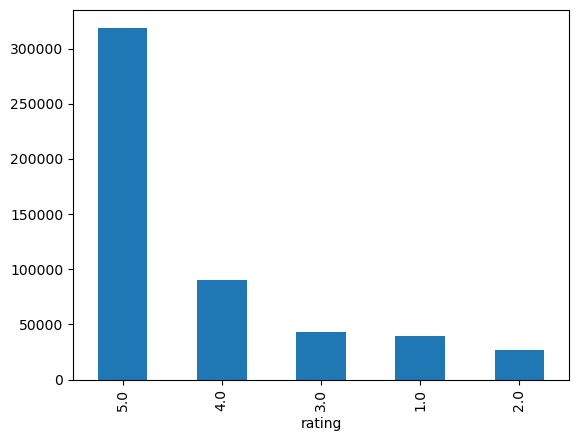

In [12]:
train_dataset['rating'].value_counts().plot(kind='bar')

- Review lengths are mostly under 2000 characters, with outliers up to 14,000 characters.

<Axes: >

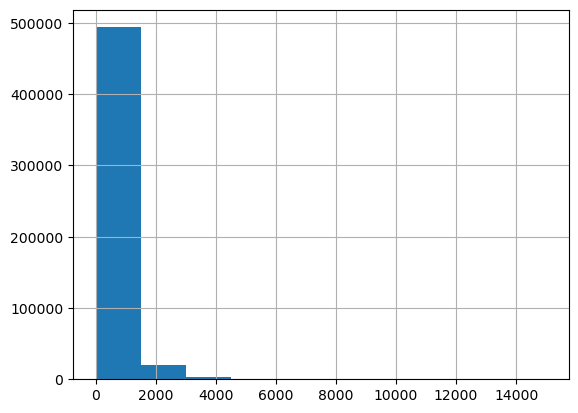

In [13]:
review_length = train_dataset['text'].map(lambda x: len(str(x)))
review_length.hist()

- Need to handle tags such as \<br> appropriately.

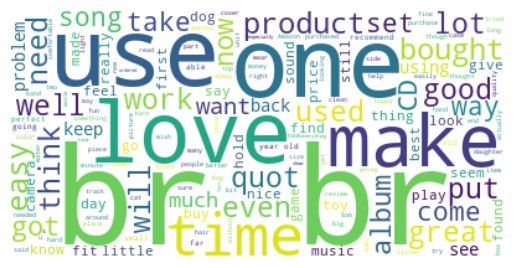

In [14]:
text = " ".join(i for i in train_dataset.text)

wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

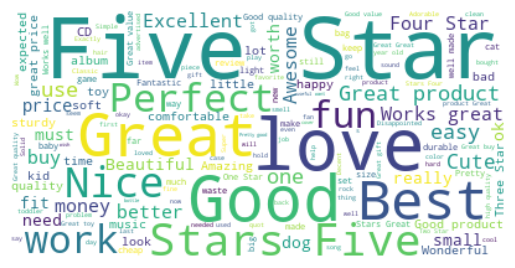

In [108]:
text = " ".join(i for i in train_dataset.title)

wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: >

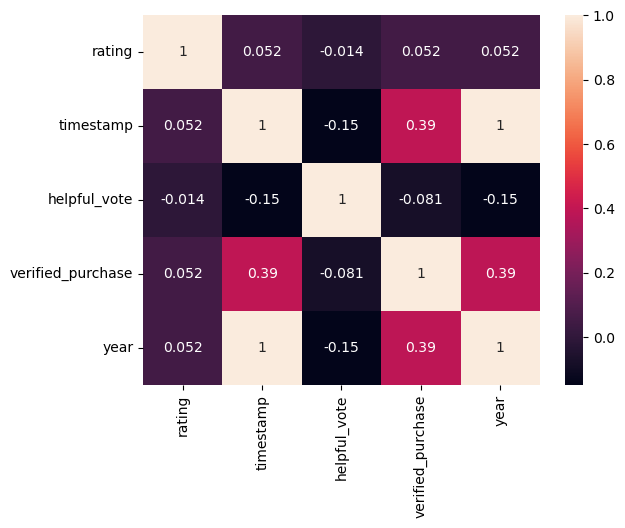

In [34]:
corr = train_dataset.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

# Data Preprocessing
- Remove unnecessary columns.

In the 'Review' and 'Title' column
- Convert the text to lowercase.
- Remove numerical characters and punctuation marks.
- Remove HTML tags.

In [91]:
processed_train_dataset = train_dataset.copy()
processed_test_dataset = test_dataset.copy()

In [92]:
processed_train_dataset = processed_train_dataset.drop(labels=["images", "asin", "parent_asin", "user_id", "timestamp", "verified_purchase"], axis=1)
processed_test_dataset = processed_test_dataset.drop(labels=["images", "asin", "parent_asin", "user_id", "timestamp", "verified_purchase"], axis=1)

In [93]:
def clean_text(text):
    cleaned_text = text.lower()
    cleaned_text = re.sub(r"can't ", "cannot ", cleaned_text)
    cleaned_text = re.sub(r"n't ", " not ", cleaned_text)
    cleaned_text = re.sub(r"i'm ", "i am ", cleaned_text)
    cleaned_text = re.sub(r"\'re ", " are ", cleaned_text)
    cleaned_text = re.sub(r"\'ve ", " have ", cleaned_text)
    cleaned_text = re.sub(r"\'ll ", " will ", cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    cleaned_text = re.sub(' {2, }', ' ', cleaned_text)
    cleaned_text = re.sub(r'(\n(\s)*){2,}', '\n', cleaned_text)
    cleaned_text = BeautifulSoup(cleaned_text, "html.parser").text
    cleaned_text = cleaned_text.strip(' ')
    return cleaned_text

In [94]:
processed_train_dataset['text'] = processed_train_dataset['text'].map(lambda t: clean_text(t))
processed_train_dataset['title'] = processed_train_dataset['title'].map(lambda t: clean_text(t))
processed_test_dataset['text'] = processed_test_dataset['text'].map(lambda t: clean_text(t))
processed_test_dataset['title'] = processed_test_dataset['title'].map(lambda t: clean_text(t))

- Remove rare words (appearing only once).

In [95]:
word_counts = pd.Series(' '.join(processed_train_dataset['text']).split()).value_counts()
rare_words = word_counts[word_counts == 1]
print(rare_words)

olufsenbr            1
nonfrenchspeaking    1
userfor              1
petdirtsunlight      1
taka                 1
                    ..
resounded            1
julianas             1
selflaunched         1
alines               1
nowadayebr           1
Name: count, Length: 210082, dtype: int64


- Tokenize the text and remove stopwords.

In [79]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heejuhwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/heejuhwang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/heejuhwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [96]:
def tokenize_remove_words(text, rm_words=True):
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english')).union(stopwords.words('spanish'))
    result = [word for word in tokens if not word in stop_words and not word in rare_words] if rm_words else tokens
    return result if len(result) > 0 else None

In [97]:
processed_train_dataset['text_tokenized'] = processed_train_dataset['text'].map(lambda t: tokenize_remove_words(t))
processed_train_dataset['title_tokenized'] = processed_train_dataset['title'].map(lambda t: tokenize_remove_words(t, rm_words=False))

processed_test_dataset['text_tokenized'] = processed_test_dataset['text'].map(lambda t: tokenize_remove_words(t))
processed_test_dataset['title_tokenized'] = processed_test_dataset['title'].map(lambda t: tokenize_remove_words(t, rm_words=False))

In [98]:
processed_train_dataset['text_tokenized']

0        [absolutely, love, oil, smell, amazing, wish, ...
1                [brush, fell, apart, low, quality, price]
2                                                     None
3        [really, researched, hemp, hearts, went, amazo...
4        [vino, size, size, br, espacio, size, pusieron...
                               ...                        
65363    [game, one, worst, ever, playedi, buy, amazonc...
65364    [shrinky, dinks, classic, glad, see, back, new...
65365    [leap, pad, great, toy, however, gone, pens, w...
65366    [month, old, ibr, bought, first, monthbr, last...
65367    [received, game, gift, really, great, book, co...
Name: text_tokenized, Length: 517949, dtype: object

In [99]:
processed_train_dataset['title_tokenized']

0                                        [perfection]
1                                      [bad, product]
2                                              [nada]
3                                   [very, satisfied]
4                         [el, tamaño, de, las, uñas]
                             ...                     
65363    [i, would, not, recommend, this, to, anyone]
65364                [yay, shrinky, dinks, are, back]
65365             [why, has, not, anyone, said, this]
65366                            [my, son, loves, it]
65367                                [a, great, game]
Name: title_tokenized, Length: 517949, dtype: object

In [101]:
processed_train_dataset = processed_train_dataset.dropna(subset=['text_tokenized', 'title_tokenized'])
processed_test_dataset = processed_test_dataset.dropna(subset=['text_tokenized', 'title_tokenized'])

- Perform lemmatization.

In [84]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/heejuhwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/heejuhwang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [102]:
processed_train_dataset['text_tokenized']

0        [absolutely, love, oil, smell, amazing, wish, ...
1                [brush, fell, apart, low, quality, price]
3        [really, researched, hemp, hearts, went, amazo...
4        [vino, size, size, br, espacio, size, pusieron...
5        [moved, montana, small, apt, attached, big, sh...
                               ...                        
65363    [game, one, worst, ever, playedi, buy, amazonc...
65364    [shrinky, dinks, classic, glad, see, back, new...
65365    [leap, pad, great, toy, however, gone, pens, w...
65366    [month, old, ibr, bought, first, monthbr, last...
65367    [received, game, gift, really, great, book, co...
Name: text_tokenized, Length: 516682, dtype: object

In [103]:
lemmatizer = WordNetLemmatizer()

processed_train_dataset['text_tokenized'] = processed_train_dataset['text_tokenized'].map(lambda x: [lemmatizer.lemmatize(token) for token in x])
processed_train_dataset['title_tokenized'] = processed_train_dataset['title_tokenized'].map(lambda x: [lemmatizer.lemmatize(token) for token in x])
processed_test_dataset['text_tokenized'] = processed_test_dataset['text_tokenized'].map(lambda x: [lemmatizer.lemmatize(token) for token in x])
processed_test_dataset['title_tokenized'] = processed_test_dataset['title_tokenized'].map(lambda x: [lemmatizer.lemmatize(token) for token in x])

In [104]:
processed_train_dataset['text_tokenized']

0        [absolutely, love, oil, smell, amazing, wish, ...
1                [brush, fell, apart, low, quality, price]
3        [really, researched, hemp, heart, went, amazon...
4        [vino, size, size, br, espacio, size, pusieron...
5        [moved, montana, small, apt, attached, big, sh...
                               ...                        
65363    [game, one, worst, ever, playedi, buy, amazonc...
65364    [shrinky, dink, classic, glad, see, back, new,...
65365    [leap, pad, great, toy, however, gone, pen, we...
65366    [month, old, ibr, bought, first, monthbr, last...
65367    [received, game, gift, really, great, book, co...
Name: text_tokenized, Length: 516682, dtype: object

In [105]:
processed_train_dataset['title_tokenized']

0                                        [perfection]
1                                      [bad, product]
3                                   [very, satisfied]
4                          [el, tamaño, de, la, uñas]
5                            [i, love, your, product]
                             ...                     
65363    [i, would, not, recommend, this, to, anyone]
65364                 [yay, shrinky, dink, are, back]
65365              [why, ha, not, anyone, said, this]
65366                             [my, son, love, it]
65367                                [a, great, game]
Name: title_tokenized, Length: 516682, dtype: object

The word cloud indicates that special characters present in the raw data are removed effectively.

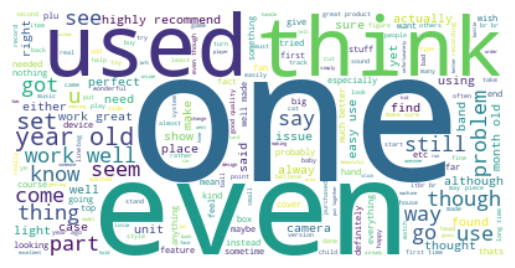

In [106]:
text = " ".join(" ".join(i) for i in processed_train_dataset.text_tokenized)

wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

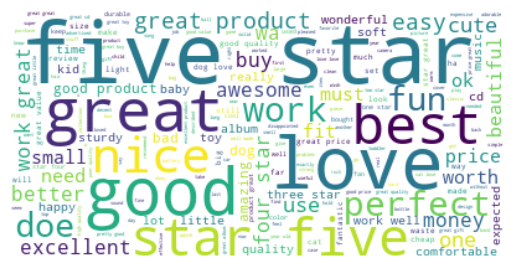

In [107]:
text = " ".join(" ".join(i) for i in processed_train_dataset.title_tokenized)

wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Split train/validation dataset

In [109]:
train_df, val_df = train_test_split(processed_train_dataset, test_size=0.2, stratify=processed_train_dataset['category'])

print(f"Train Dataset: {train_df.shape}")
print(f"Validation Dataset: {val_df.shape}")
print(f"Test Dataset: {processed_test_dataset.shape}")

Train Dataset: (413345, 8)
Validation Dataset: (103337, 8)
Test Dataset: (226084, 8)


In [110]:
train_df.to_csv("./dataset/train_data.csv")
val_df.to_csv("./dataset/val_data.csv")
processed_test_dataset.to_csv("./dataset/test_data.csv")

# References
- Data: https://amazon-reviews-2023.github.io/data_loading/jsonl.html
- https://www.kaggle.com/code/mehmetisik/amazon-reviews-boosting-sales-sentiment-analysis
- https://github.com/reasonmii/project-toxic-comment-classification/blob/main/Yuna-Supervised/Toxic-Classification.ipynb